In [20]:
import numpy as np
import xarray as xr
import matplotlib as mpl 
from scipy.stats import linregress 

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from src import  utils
from concurrent.futures import ProcessPoolExecutor

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# DEFINE DIRECTORIES HERE
ERSST_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/ERSST/"
HADIS_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/HadISST/"
COBES_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/COBE_SST2/"

GPCC_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/GPCC/full_v2020/"
CRUT_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/CRU_TS4.06/"
APHR_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/APHRODITE/"

In [22]:
# List of CESM2 Ensemble Members
members = ['LE2-1001.001', 'LE2-1011.001', 'LE2-1021.002', 'LE2-1031.002', 'LE2-1041.003', 'LE2-1051.003',
            'LE2-1061.004', 'LE2-1071.004', 'LE2-1081.005', 'LE2-1091.005', 'LE2-1101.006', 'LE2-1111.006',
            'LE2-1121.007', 'LE2-1131.007', 'LE2-1141.008', 'LE2-1151.008', 'LE2-1161.009', 'LE2-1171.009',
            'LE2-1181.010', 'LE2-1191.010', 
            'LE2-1231.001', 'LE2-1231.002', 'LE2-1231.003', 'LE2-1231.004',
            'LE2-1231.005', 'LE2-1231.006', 'LE2-1231.007', 'LE2-1231.008', 'LE2-1231.009', 'LE2-1231.010',
            'LE2-1231.011', 'LE2-1231.012', 'LE2-1231.013', 'LE2-1231.014', 'LE2-1231.015', 'LE2-1231.016',
            'LE2-1231.017', 'LE2-1231.018', 'LE2-1231.019', 'LE2-1231.020',
            'LE2-1251.001', 'LE2-1251.002', 'LE2-1251.003', 'LE2-1251.004',
            'LE2-1251.005', 'LE2-1251.006', 'LE2-1251.007', 'LE2-1251.008', 'LE2-1251.009', 'LE2-1251.010',
            'LE2-1251.011', 'LE2-1251.012', 'LE2-1251.013', 'LE2-1251.014', 'LE2-1251.015', 'LE2-1251.016',
            'LE2-1251.017', 'LE2-1251.018', 'LE2-1251.019', 'LE2-1251.020',
            'LE2-1301.001', 'LE2-1301.002', 'LE2-1301.003', 'LE2-1301.004', 'LE2-1301.005', 'LE2-1301.006',
            'LE2-1301.007', 'LE2-1301.008', 'LE2-1301.009', 'LE2-1301.010', 'LE2-1301.011', 'LE2-1301.012', 
            'LE2-1301.013', 'LE2-1301.014', 'LE2-1301.015', 'LE2-1301.016', 'LE2-1301.017', 'LE2-1301.018',
            'LE2-1301.019', 'LE2-1301.020',
            'LE2-1281.001', 'LE2-1281.002', 'LE2-1281.003', 'LE2-1281.004', 'LE2-1281.005', 'LE2-1281.006',
            'LE2-1281.007', 'LE2-1281.008', 'LE2-1281.009', 'LE2-1281.010', 'LE2-1281.011', 'LE2-1281.012',
            'LE2-1281.013', 'LE2-1281.014', 'LE2-1281.015', 'LE2-1281.016', 'LE2-1281.017', 'LE2-1281.018',
            'LE2-1281.019', 'LE2-1281.020']
print(len(members))

100


In [23]:
# Open all precip. datasets
precip_anm_G = utils.get_obs_precip_anomalies(
    source="GPCC", 
    months=[3, 4, 5], detrend=False
    )

precip_anm_C = utils.get_obs_precip_anomalies(
    source="CRUT", 
    months=[3, 4, 5], detrend=False
    )

precip_anm_A = utils.get_obs_precip_anomalies(
    source="APHR", 
    months=[3, 4, 5], detrend=False
    )

In [24]:
# Open all Nino3.4 SST datasets
sst_anm_nino34_E = utils.get_obs_nino34_sst_anomalies(
    source="ERSST",
    detrend=False
)

sst_anm_nino34_H = utils.get_obs_nino34_sst_anomalies(
    source="HADISST", 
    detrend=False
)

sst_anm_nino34_C = utils.get_obs_nino34_sst_anomalies(
    source="COBESST", 
    detrend=False
)

In [25]:
def plot_line(x, y, ax, color):
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Generate x values for the trend line
    x_fit = np.linspace(np.min(x), np.max(x), 100)
    y_fit = intercept + slope * x_fit

    ax.plot(x_fit, y_fit, color=color, linestyle='--')
    
    return slope

In [26]:
precip_anms = [
    precip_anm_G # G,C,A
]

sst_anm_nino34s = [
    sst_anm_nino34_E #E,H,C
]

In [27]:
# Open CESM2-LE data for running correlation
N=13 # running mean correlation
def process_member(ens):
    print(f"Processing {ens}")
    monthly_sst_da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.SST.Nino34.nc")
    sst_anm = utils.get_model_sst_anomalies(monthly_sst_da, detrend=False)
    
    prec_da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.PRECT.MSEA.nc")
    precip_anm = utils.get_model_precip_anomalies(prec_da, months=[3,4,5], detrend=False)

    print("Getting running correlation...")
    corr_lead = utils.get_running_corr(precip_anm, sst_anm.shift(time=1), window=N)
    
    return (corr_lead, precip_anm, sst_anm)
    
def main(members):
    lead_correlations = []
    all_precips = []
    all_ssts = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        corr_lead, precip_anm, sst_anm = result
        lead_correlations.append(corr_lead)
        all_precips.append(precip_anm)
        all_ssts.append(sst_anm)
    return lead_correlations, all_precips, all_ssts

lead_correlations, all_precips, all_ssts = main(members)

Processing LE2-1001.001
Processing LE2-1011.001
Processing LE2-1021.002
Processing LE2-1031.002
Processing LE2-1041.003
Processing LE2-1051.003
Processing LE2-1061.004
Processing LE2-1071.004
Processing LE2-1081.005
Processing LE2-1091.005
Processing LE2-1101.006
Processing LE2-1111.006
Processing LE2-1121.007
Processing LE2-1131.007
Processing LE2-1141.008
Processing LE2-1151.008
Processing LE2-1181.010
Processing LE2-1191.010
Processing LE2-1231.001Processing LE2-1161.009Processing LE2-1171.009


Processing LE2-1231.002

Processing LE2-1231.003Processing LE2-1231.004
Processing LE2-1231.005
Processing LE2-1231.006
Processing LE2-1231.007
Processing LE2-1231.008
Getting running correlation...
Processing LE2-1231.009
Processing LE2-1231.010Getting running correlation...

Processing LE2-1231.011
Getting running correlation...
Processing LE2-1231.012
Processing LE2-1231.013
Processing LE2-1231.014
Processing LE2-1231.015
Getting running correlation...Getting running correlation...Getting

In [28]:
lead_correlations_da = xr.concat(lead_correlations, dim='ensemble')
precips_da = xr.concat(all_precips, dim='ensemble')
ssts_da = xr.concat(all_ssts, dim='ensemble')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_2381479/2016301487.py:108: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("Fig4.png")
/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


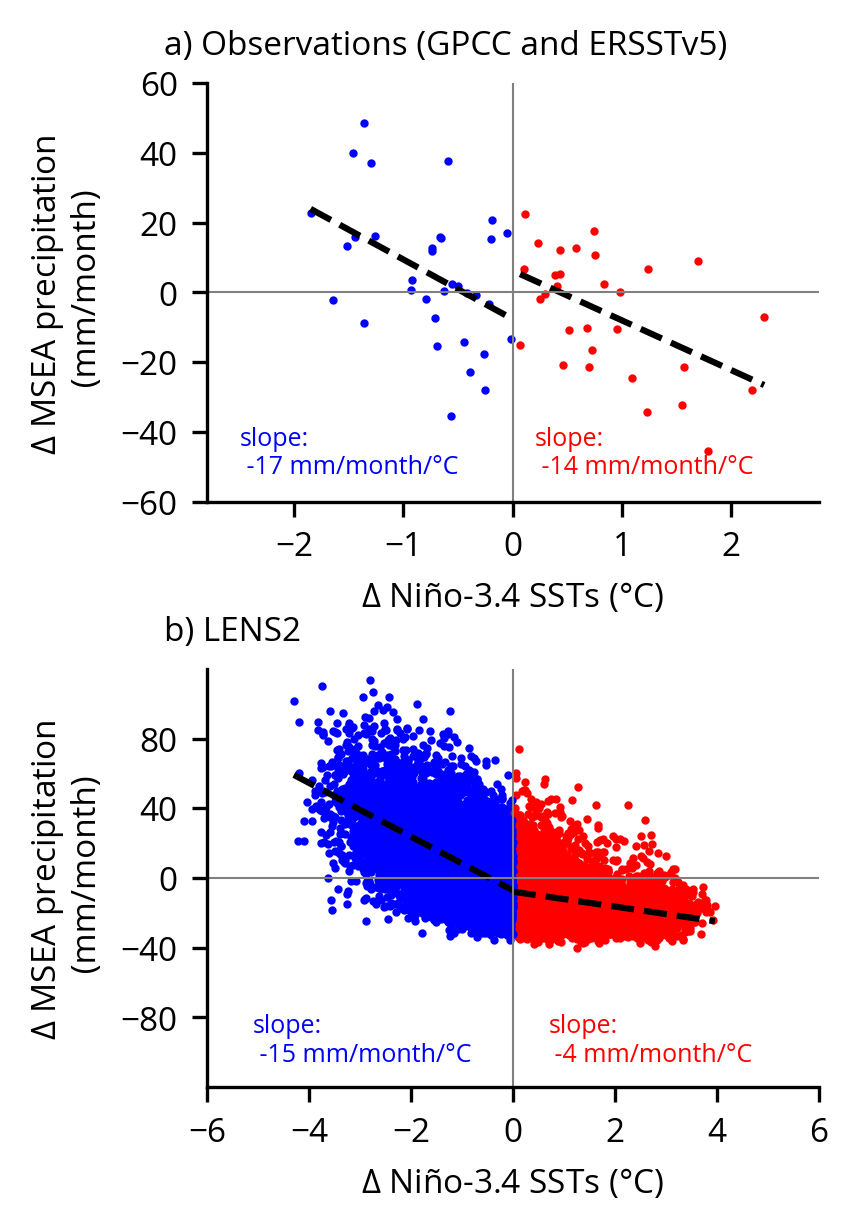

In [35]:
precip_anms = [
    precip_anm_G # G,C,A
]

sst_anm_nino34s = [
    sst_anm_nino34_E #E,H,C
]


%matplotlib inline 

utils.set_matplotlib_font("Open Sans")
mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

fig_width_cm = 7
fig_height_cm = 10
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300, constrained_layout=True)

gs1 = GridSpec(2, 1, top=0.95, bottom=0.10, left=0.24, right=0.98, hspace=0.4, wspace=0.2)

ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[1, 0])

############## Figure 4a ##############

for precip_anm, sst_anm_nino34 in zip(precip_anms, sst_anm_nino34s):
    sst_shifted = sst_anm_nino34.shift(time=1)

    precip_anm = precip_anm.sel(time=slice('1951','2015'))
    sst_shifted = sst_shifted.sel(time=slice('1951','2015'))

    elnino_sst = sst_shifted.where(sst_shifted>0, drop=True).values
    lanina_sst = sst_shifted.where(sst_shifted<0, drop=True).values
    
    elnino_pre = precip_anm.where(sst_shifted>0, drop=True).values
    lanina_pre = precip_anm.where(sst_shifted<0, drop=True).values


    ax1.scatter(elnino_sst,elnino_pre,color="red", s=1)
    ax1.scatter(lanina_sst,lanina_pre,color="blue", s=1)
    
    slope = plot_line(elnino_sst, elnino_pre, ax=ax1, color='k')
    ax1.text(0.2, -52, f'slope:\n {slope:.0f} mm/month/°C', color='red', fontsize=6)

    slope = plot_line(lanina_sst, lanina_pre, ax=ax1, color='k')
    ax1.text(-2.5, -52, f'slope:\n {slope:.0f} mm/month/°C', color='blue', fontsize=6)

############## Figure 4b ##############

sst_shifted = ssts_da.shift(time=1)

precip_anm = precips_da.sel(time=slice('1900','2015'))
sst_shifted = sst_shifted.sel(time=slice('1900','2015'))

elnino_sst = sst_shifted.where(sst_shifted>0, drop=True).values
lanina_sst = sst_shifted.where(sst_shifted<0, drop=True).values
    
elnino_pre = precip_anm.where(sst_shifted>0, drop=True).values
lanina_pre = precip_anm.where(sst_shifted<0, drop=True).values


ax2.scatter(elnino_sst, elnino_pre,color="red", s=1)
ax2.scatter(lanina_sst, lanina_pre,color="blue", s=1)

slope = plot_line(elnino_sst[~np.isnan(elnino_sst)].flatten(), elnino_pre[~np.isnan(elnino_pre)].flatten(), ax=ax2, color='black')
ax2.text(0.7, -105, f'slope:\n {slope:.0f} mm/month/°C', color='red', fontsize=6)
slope = plot_line(lanina_sst[~np.isnan(lanina_sst)].flatten(), lanina_pre[~np.isnan(lanina_pre)].flatten(), ax=ax2, color='black')
ax2.text(-5.1, -105, f'slope:\n {slope:.0f} mm/month/°C', color='blue', fontsize=6)

ax1.set_xlim(-2.8,2.8)
ax2.set_xlim(-6, 6)

ax1.set_ylim(-60,60)
ax2.set_ylim(-120,120)
ax2.set_yticks([-80, -40, 0, 40, 80])

ax2.legend()

for ax in [ax1, ax2]:
    ax.set_xlabel("$\Delta$ Niño-3.4 SSTs (°C)")
    ax.set_ylabel("$\Delta$ MSEA precipitation \n (mm/month)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='lower left', frameon=False, fontsize=6)
    ax.axhline(0, color='grey', linewidth=0.5)
    ax.axvline(0, color='grey', linewidth=0.5)


# Set subplot labels
titles1 = ["a) Observations (GPCC and ERSSTv5)", "b) LENS2"]
titles2 = [None, None]
colors = ['k', 'k']
for i, (ax, title1, title2) in enumerate(zip([ax1, ax2], titles1, titles2)):
    ax.annotate(title1, xy=(-0.07, 1.05), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='bottom')
    ax.annotate(title2, xy=(0, 1.05), xycoords='axes fraction', fontsize=8, color=colors[i], ha='left', va='bottom')

plt.savefig("Fig4.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_2381479/4288961001.py:113: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("FigS5.png")
/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


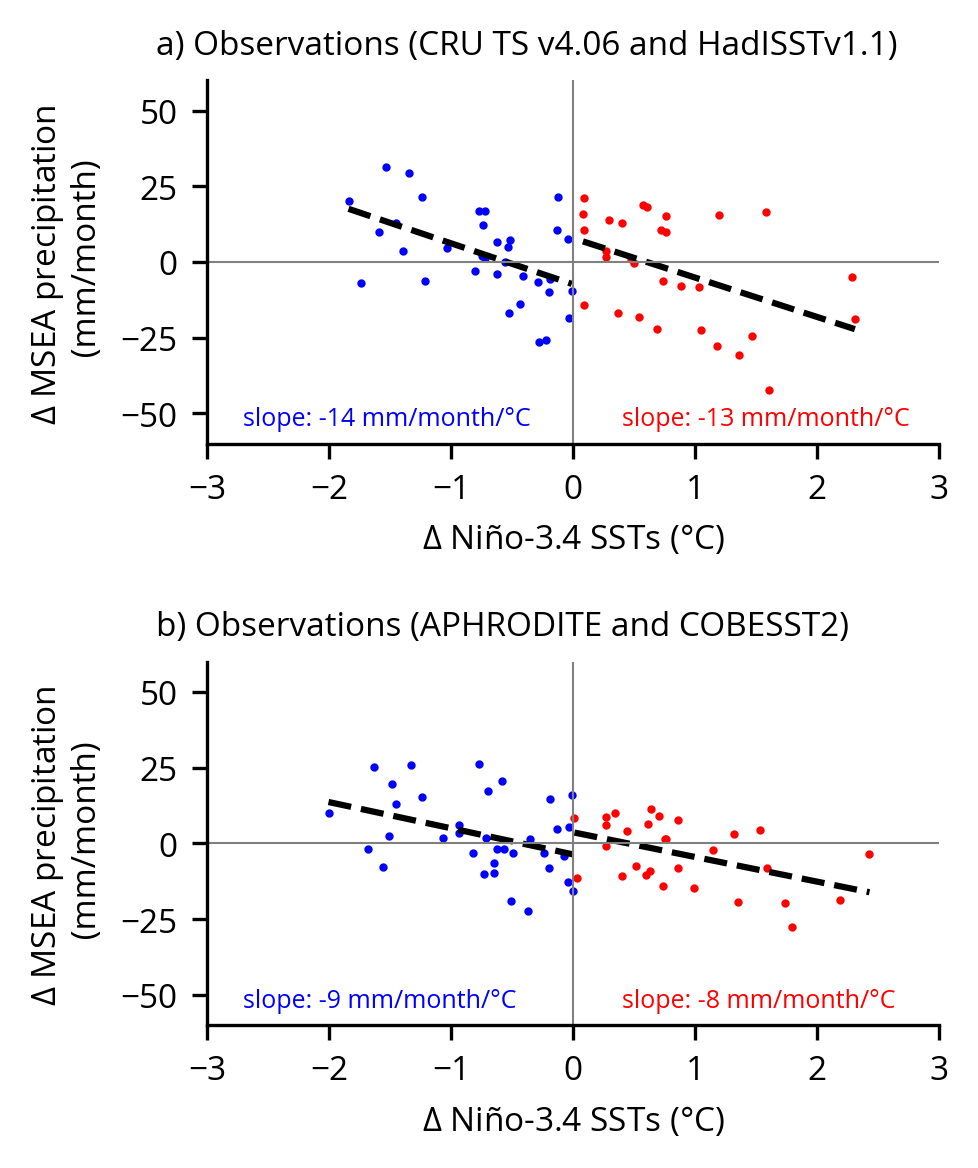

In [31]:
%matplotlib inline 

utils.set_matplotlib_font("Open Sans")
mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

fig_width_cm = 8
fig_height_cm = 10
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300, constrained_layout=True)

gs1 = GridSpec(2, 1, top=0.90, bottom=0.10, hspace=0.6, wspace=0.2)

ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[1, 0])

############## Figure 4a ##############

precip_anms = [
    precip_anm_C # G,C,A
]

sst_anm_nino34s = [
    sst_anm_nino34_H #E,H,C
]


for precip_anm, sst_anm_nino34 in zip(precip_anms, sst_anm_nino34s):
    sst_shifted = sst_anm_nino34.shift(time=1)

    precip_anm = precip_anm.sel(time=slice('1951','2015'))
    sst_shifted = sst_shifted.sel(time=slice('1951','2015'))

    elnino_sst = sst_shifted.where(sst_shifted>0, drop=True).values
    lanina_sst = sst_shifted.where(sst_shifted<0, drop=True).values
    
    elnino_pre = precip_anm.where(sst_shifted>0, drop=True).values
    lanina_pre = precip_anm.where(sst_shifted<0, drop=True).values


    ax1.scatter(elnino_sst,elnino_pre,color="red", s=1)
    ax1.scatter(lanina_sst,lanina_pre,color="blue", s=1)
    
    slope = plot_line(elnino_sst, elnino_pre, ax=ax1, color='k')
    ax1.text(0.4, -54, f'slope: {slope:.0f} mm/month/°C', color='red', fontsize=6)

    slope = plot_line(lanina_sst, lanina_pre, ax=ax1, color='k')
    ax1.text(-2.7, -54, f'slope: {slope:.0f} mm/month/°C', color='blue', fontsize=6)

############## Figure 4b ##############


precip_anms = [
    precip_anm_A # G,C,A
]

sst_anm_nino34s = [
    sst_anm_nino34_C #E,H,C
]

for precip_anm, sst_anm_nino34 in zip(precip_anms, sst_anm_nino34s):
    sst_shifted = sst_anm_nino34.shift(time=1)

    precip_anm = precip_anm.sel(time=slice('1951','2015'))
    sst_shifted = sst_shifted.sel(time=slice('1951','2015'))

    elnino_sst = sst_shifted.where(sst_shifted>0, drop=True).values
    lanina_sst = sst_shifted.where(sst_shifted<0, drop=True).values
    
    elnino_pre = precip_anm.where(sst_shifted>0, drop=True).values
    lanina_pre = precip_anm.where(sst_shifted<0, drop=True).values


    ax2.scatter(elnino_sst,elnino_pre,color="red", s=1)
    ax2.scatter(lanina_sst,lanina_pre,color="blue", s=1)
    
    slope = plot_line(elnino_sst, elnino_pre, ax=ax2, color='k')
    ax2.text(0.4, -54, f'slope: {slope:.0f} mm/month/°C', color='red', fontsize=6)

    slope = plot_line(lanina_sst, lanina_pre, ax=ax2, color='k')
    ax2.text(-2.7, -54, f'slope: {slope:.0f} mm/month/°C', color='blue', fontsize=6)


for ax in [ax1, ax2]:
    ax.set_xlim(-3,3)
    ax.set_ylim(-60,60)
    ax.set_xlabel("$\Delta$ Niño-3.4 SSTs (°C)")
    ax.set_ylabel("$\Delta$ MSEA precipitation \n (mm/month)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='lower left', frameon=False, fontsize=6)
    ax.axhline(0, color='grey', linewidth=0.5)
    ax.axvline(0, color='grey', linewidth=0.5)


# Set subplot labels
titles1 = ["a) Observations (CRU TS v4.06 and HadISSTv1.1)", "b) Observations (APHRODITE and COBESST2)"]
titles2 = [None, None]
colors = ['k', 'k']
for i, (ax, title1, title2) in enumerate(zip([ax1, ax2], titles1, titles2)):
    ax.annotate(title1, xy=(-0.07, 1.05), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='bottom')
    ax.annotate(title2, xy=(0, 1.05), xycoords='axes fraction', fontsize=8, color=colors[i], ha='left', va='bottom')

plt.savefig("FigS6.png")
